
# Principal Component Regression (PCR): From Theory to Practice

This notebook is a complete, hands‑on guide to **Principal Component Regression (PCR)**.  
You’ll get:
- The math behind PCA and PCR (with clear notation).
- A step‑by‑step algorithmic recipe.
- A full implementation with `scikit‑learn`.
- Visualizations: variance explained, CV model selection, predictions & residuals.
- How to map PCR coefficients back to the original feature space.

---



## Why PCR? (Intuition)
When features are **highly correlated** (multicollinearity), ordinary least squares (OLS) becomes unstable: small noise can cause large swings in coefficients.  
**Principal Component Regression** fixes this by:
1. Doing **PCA** on the features $X$ (usually after standardizing).
2. Keeping only the first $k$ principal components (PCs) that capture most variance.
3. Regressing $y$ on those $k$ PCs.

This shrinks the effective hypothesis space and often improves generalization when $p$ is large or features are collinear.



## Math Background

Let the (centered) data matrix be $X \in \mathbb{R}^{n \times p}$ and the target vector $y \in \mathbb{R}^{n}$.  
**PCA** computes an SVD
$$
X \;=\; U\Sigma V^\top,
$$
where
- $U \in \mathbb{R}^{n \times r}$ with $U^\top U = I_r$,
- $\Sigma = \mathrm{diag}(\sigma_1,\dots,\sigma_r)$ with $\sigma_1 \ge \cdots \ge \sigma_r > 0$,
- $V \in \mathbb{R}^{p \times r}$ with $V^\top V = I_r$,
and $r = \mathrm{rank}(X) \le \min(n,p)$.

The **scores** (principal component features) are
$$
Z \;=\; X V \;=\; U \Sigma \in \mathbb{R}^{n \times r}.
$$

In **PCR** with $k$ components ($1 \le k \le r$), we regress $y$ on the first $k$ columns of $Z$:
$$
\hat{\gamma} \;=\; \arg\min_{\gamma \in \mathbb{R}^{k}} \;\|\, y - Z_k \gamma \,\|_2^2,
\quad\text{where } Z_k = X V_k.
$$

The fitted coefficient vector in the **original feature space** is
$$
\hat{\beta}_{\text{PCR}} \;=\; V_k \hat{\gamma}.
$$

If you standardize features via $X = (X_{\text{raw}} - \mu) \, S^{-1}$ where $S$ is diagonal with feature standard deviations, then the raw‑space coefficients are recovered by
$$
\hat{\beta}_{\text{raw}} \;=\; S^{-1} \hat{\beta}_{\text{PCR}},
\qquad
\hat{\beta}_0 \;=\; \bar{y} - \mu^\top \hat{\beta}_{\text{raw}}.
$$

**Explained variance ratio** of component $j$ is
$$
\mathrm{EVR}_j \;=\; \frac{\sigma_j^2}{\sum_{i=1}^{r}\sigma_i^2}.
$$

**Model selection:** choose $k$ by cross‑validation to minimize validation error:
$$
k^\star \;=\; \arg\min_{k \in \{1,\dots,r\}} \mathrm{CV\_MSE}(k).
$$


In [1]:

# Imports
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)
np.random.seed(42)



## Create a Synthetic, Collinear Regression Problem
We’ll generate a dataset where features are intentionally correlated to showcase the benefit of PCR.


In [2]:

# Create a synthetic dataset with multicollinearity
n_samples = 600
n_features = 20
effective_rank = 5   # lower rank structure to induce correlation

X_raw, y, coef_true = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=8,
    noise=12.0,
    coef=True,
    effective_rank=effective_rank,
    random_state=42
)

# Add a few nearly duplicate columns to crank up collinearity further
X_raw = np.hstack([X_raw, X_raw[:, [0]] + 0.01*rng.normal(size=(n_samples,1)), X_raw[:, [1]] + 0.01*rng.normal(size=(n_samples,1))])
feature_names = [f"x{j+1}" for j in range(X_raw.shape[1])]

df = pd.DataFrame(X_raw, columns=feature_names)
df["y"] = y
df.head()


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,y
0,-0.031320,0.037180,0.006600,0.016926,0.003758,-0.001509,0.018068,-0.019238,0.026767,0.031745,...,-0.003760,0.006131,0.040186,-0.002078,0.006290,-0.040407,-0.011040,-0.028273,0.042334,18.343058
1,0.019690,0.001216,-0.008744,-0.019007,-0.005172,0.010085,-0.001322,0.000882,0.011032,-0.024060,...,0.022527,-0.019141,0.003190,-0.022541,-0.021640,-0.015174,-0.014384,0.009290,-0.004559,-28.716675
2,-0.016630,0.004551,0.010751,-0.023812,0.003863,-0.040883,0.040937,-0.010915,0.012181,0.004859,...,0.025498,0.011013,-0.029724,-0.013430,-0.003558,0.004854,-0.031568,-0.009126,0.017296,0.510618
3,0.011846,-0.030744,-0.001658,-0.016431,0.009297,-0.002440,0.021330,0.055035,0.006317,0.010098,...,-0.046353,-0.007312,-0.008524,-0.004868,0.006035,0.035205,-0.008666,0.021252,-0.037020,6.656056
4,0.060935,0.047161,-0.030171,0.022839,0.024452,0.019207,-0.046352,0.033896,0.014628,-0.036352,...,-0.011141,0.034470,-0.043826,-0.039816,-0.021087,-0.020987,0.009014,0.041425,0.040795,25.837871


In [3]:

# Split train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.25, random_state=42
)
X_train_raw.shape, X_test_raw.shape


((450, 22), (150, 22))


## Building a PCR Pipeline
We’ll standardize features, apply PCA, keep the first $k$ PCs, and then fit linear regression on those scores.
We also include helpers to **reconstruct coefficients back** to the original feature space.


In [4]:

def fit_pcr(X_train_raw, y_train, n_components):
    """
    Fit a PCR model:
      - Standardize X
      - PCA with n_components
      - Linear regression on component scores
    Returns: pipeline, scaler, pca, linear_model
    """
    scaler = StandardScaler(with_mean=True, with_std=True)
    pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
    lr = LinearRegression()

    # We use a manual pipeline to access internals easily
    Xs = scaler.fit_transform(X_train_raw)
    Z = pca.fit_transform(Xs)  # principal component scores
    lr.fit(Z, y_train)

    return scaler, pca, lr

def pcr_predict(scaler, pca, lr, X_raw):
    Xs = scaler.transform(X_raw)
    Z = pca.transform(Xs)
    return lr.predict(Z)

def recover_original_coefficients(scaler, pca, lr):
    """
    Recover coefficients in the original raw feature space.
    For standardized X: Xs = (X_raw - mu)/sigma, with sigma = scaler.scale_
    PCA scores: Z = Xs V   (sklearn PCA.components_ is V^T)
    Regression: y ~ Z * gamma + b
    Raw-space beta: beta_raw = (1/sigma) * V_k * gamma
    Intercept: beta0 = b - mu^T * beta_raw
    """
    Vt = pca.components_  # shape (k, p)
    V = Vt.T              # shape (p, k)
    gamma = lr.coef_      # shape (k,)
    sigma = scaler.scale_ # shape (p,)
    mu = scaler.mean_     # shape (p,)

    beta_pcr = V @ gamma                  # (p,)
    beta_raw = beta_pcr / sigma           # (p,)
    beta0 = lr.intercept_ - mu @ beta_raw # scalar
    return beta0, beta_raw



## Choose the Number of Components $k$ via Cross‑Validation
We scan $k=1,\dots,p$ and pick the $k$ minimizing CV MSE on the training set.


In [5]:

p = X_train_raw.shape[1]
ks = np.arange(1, min(p, 40) + 1)  # cap at 40 for speed/clarity
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mse = []
for k in ks:
    # Build a sklearn Pipeline for CV convenience
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver='full', random_state=42)),
        ("lr", LinearRegression())
    ])
    scores = cross_val_score(pipe, X_train_raw, y_train, scoring="neg_mean_squared_error", cv=cv)
    cv_mse.append(-scores.mean())

best_k = ks[int(np.argmin(cv_mse))]
best_k, float(np.min(cv_mse))


(np.int64(14), 139.77463740140382)


## Fit the Final PCR and Compare with OLS and Ridge
We refit PCR using the best $k$ found. Then, we compare test MSE with OLS and Ridge.


In [6]:

# Final PCR
scaler, pca, lr = fit_pcr(X_train_raw, y_train, n_components=int(best_k))

# Competing baselines
ols = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=5.0))])

ols.fit(X_train_raw, y_train)
ridge.fit(X_train_raw, y_train)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred_pcr = pcr_predict(scaler, pca, lr, X_test_raw)
y_pred_ols = ols.predict(X_test_raw)
y_pred_ridge = ridge.predict(X_test_raw)

mse_pcr = mean_squared_error(y_test, y_pred_pcr)
mse_ols = mean_squared_error(y_test, y_pred_ols)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

r2_pcr = r2_score(y_test, y_pred_pcr)
r2_ols = r2_score(y_test, y_pred_ols)
r2_ridge = r2_score(y_test, y_pred_ridge)

results = pd.DataFrame({
    "Model": ["PCR", "OLS (std)", "Ridge (alpha=5)"],
    "Test MSE": [mse_pcr, mse_ols, mse_ridge],
    "Test R^2": [r2_pcr, r2_ols, r2_ridge]
})
results


,Model,Test MSE,Test R^2
0,PCR,156.989409,0.109149
1,OLS (std),168.075458,0.046240
2,Ridge (alpha=5),167.453555,0.049769



## Visualizations
We’ll plot:
1. **Explained variance ratio** across components.
2. **CV MSE vs. $k$** for model selection.
3. **Predicted vs. True** on the test set.
4. **Residuals vs. Predicted** to inspect patterns.


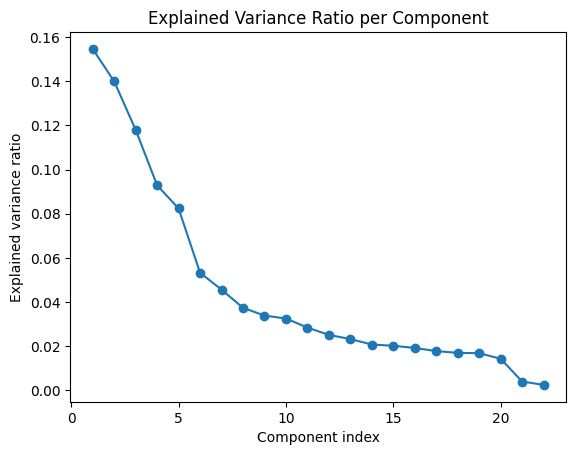

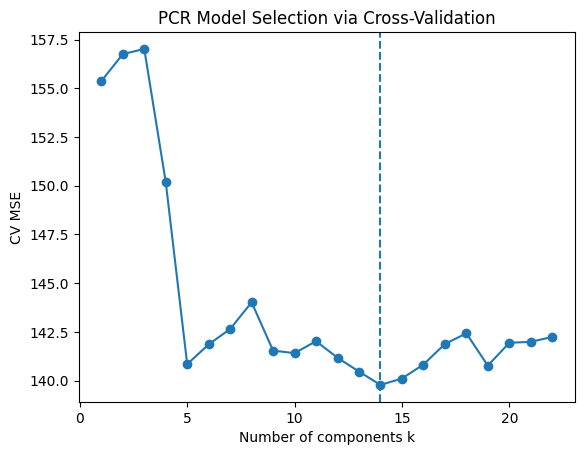

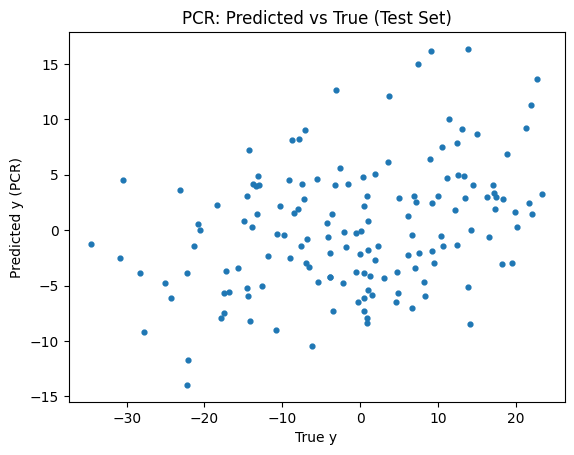

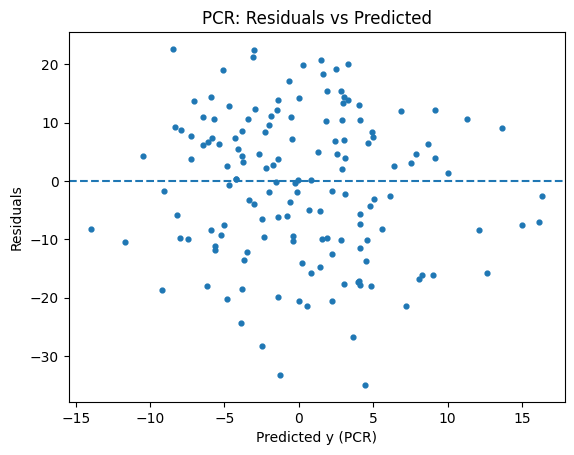

In [7]:

# 1) Explained variance ratio
plt.figure()
pca_full = PCA(n_components=min(X_train_raw.shape), svd_solver='full', random_state=42)
Xs_full = StandardScaler().fit_transform(X_train_raw)
pca_full.fit(Xs_full)
evr = pca_full.explained_variance_ratio_
plt.plot(np.arange(1, len(evr)+1), evr, marker="o")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("Explained Variance Ratio per Component")
plt.show()

# 2) CV curve
plt.figure()
plt.plot(ks, cv_mse, marker="o")
plt.axvline(best_k, linestyle="--")
plt.xlabel("Number of components k")
plt.ylabel("CV MSE")
plt.title("PCR Model Selection via Cross-Validation")
plt.show()

# 3) Predicted vs True (PCR)
plt.figure()
plt.scatter(y_test, y_pred_pcr, s=12)
plt.xlabel("True y")
plt.ylabel("Predicted y (PCR)")
plt.title("PCR: Predicted vs True (Test Set)")
plt.show()

# 4) Residuals vs Predicted (PCR)
residuals = y_test - y_pred_pcr
plt.figure()
plt.scatter(y_pred_pcr, residuals, s=12)
plt.axhline(0.0, linestyle="--")
plt.xlabel("Predicted y (PCR)")
plt.ylabel("Residuals")
plt.title("PCR: Residuals vs Predicted")
plt.show()



## Recover Coefficients in the Original Feature Space
We can interpret PCR by mapping the fitted model back to raw features.


In [8]:

beta0_raw, beta_raw = recover_original_coefficients(scaler, pca, lr)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "beta_raw": beta_raw
}).sort_values("beta_raw", key=lambda s: np.abs(s), ascending=False).reset_index(drop=True)

coef_df.head(10)


,feature,beta_raw
0,x4,110.123526
1,x19,90.222856
2,x8,61.791933
3,x2,52.698985
4,x22,52.326226
5,x18,52.323568
6,x3,49.381049
7,x5,42.791632
8,x14,-36.121320
9,x17,-35.885974



### Sanity Check
Using the recovered coefficients $(\hat{\beta}_0, \hat{\beta}_{\text{raw}})$ should reproduce the PCR predictions.


In [9]:

y_pred_check = beta0_raw + X_test_raw @ beta_raw
float(np.max(np.abs(y_pred_check - y_pred_pcr)))  # should be ~ numerical noise


5.329070518200751e-15


## Practical Notes & Limitations
- **Supervised vs. unsupervised dimensionality reduction:** PCA ignores $y$ when forming components. If you want components aligned with $y$, consider **PLS** (Partial Least Squares) instead.
- **Scaling matters:** Always standardize features before PCA/PCR.
- **Choosing $k$:** Use CV. A common heuristic is to keep PCs until, say, 95% variance is explained, but CV tied to your metric is safer.
- **Interpretability:** Raw‑space coefficients recovered above help, but PCR is still less interpretable than sparse/structured models.
- **Alternatives:** Ridge/Lasso/ElasticNet can also stabilize regression in collinear settings while staying in the original feature space.



## Appendix: From PC Coefficients to Raw Coefficients

Let standardized features be $X_s = (X_{\text{raw}} - \mu) S^{-1}$ where $S=\mathrm{diag}(\sigma_1,\dots,\sigma_p)$.  
PCA gives $X_s \approx Z V^\top$ with $Z = X_s V$. Regress $y$ on $Z_k$:
$$
\hat{\gamma} = \arg\min_{\gamma}\|y - Z_k \gamma\|_2^2,
\qquad \hat{y} = Z_k \hat{\gamma} + \hat{b}.
$$
Since $Z_k = X_s V_k$,
$$
\hat{y} = X_s V_k \hat{\gamma} + \hat{b} \;=\; (X_{\text{raw}} - \mu) S^{-1} \underbrace{V_k \hat{\gamma}}_{\hat{\beta}_{\text{PCR}}} + \hat{b}.
$$
Thus
$$
\hat{\beta}_{\text{raw}} = S^{-1} \hat{\beta}_{\text{PCR}},
\qquad
\hat{\beta}_0 = \hat{b} - \mu^\top \hat{\beta}_{\text{raw}}.
$$



## Wrap‑Up
You now have:
- A clear mathematical view of PCR.
- A robust implementation with component selection via CV.
- Visual diagnostics and a path back to raw‑space coefficients.

Feel free to swap in your own dataset — only the data loading cell needs to change.
